In [1]:
from cdlib import algorithms
import networkx.algorithms.community as nx_comm
from cdlib import viz
import networkx as nx
from cdlib import NodeClustering
import random
import numpy as np
import pandas as pd
from itertools import product
import time
import sys

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'karateclub', 'infomap', 'wurlitzer'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


In [2]:
def reformat2(G,coms): 
    hasil=[]
    for key in coms: #a_dict[key])
        if len(coms[key])>0:
            hasil.append(list(coms[key]))
    return(hasil)


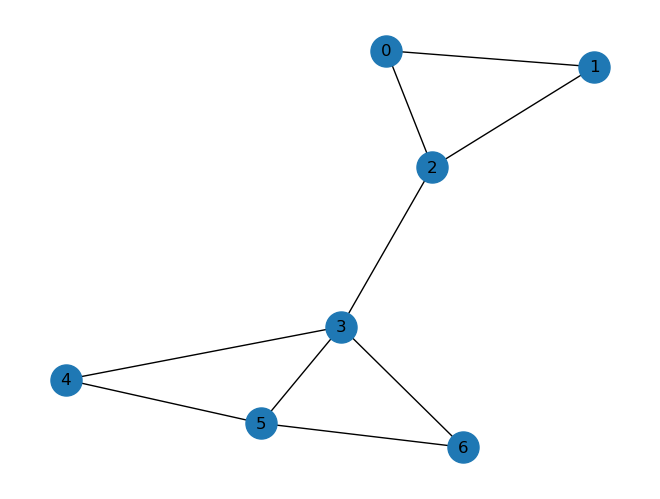

In [3]:
G=nx.Graph()
G.add_edges_from([(0,1),(1,2),(2,0),(2,3),(3,4),(4,5),(5,3),(6,5),(6,3)])
pos = nx.spring_layout(G)
G=nx.convert_node_labels_to_integers(G,first_label=0)
nx.draw(G, with_labels=True, node_size=500)

In [4]:
def cetak(s, communities):
    comm= []
    for x in communities:
        if list(x)!=[]:
            comm.append(list(x))
    print (s,' : ',comm)


In [5]:
def intersection(lst1, lst2):
    #https://stackoverflow.com/questions/54610818/difference-between-two-list-of-unordered-tuples
    if lst1 and lst2:
        lst3= set([tuple(sorted(elem))for elem in lst1]) & set([tuple(sorted(elem))for elem in lst2])
    else:
        lst3=[]
    return lst3


In [6]:
def pecah(G,communities):
    # ini draft awal pecah 
    cand=[]
    for idx in range(len(communities)):
        if (len(communities[idx])>1): # Apakah anggota comunitas berjumlah dua atau lebih
            cand.append(idx)
    if len(cand)>=1:  # bila ada yang panjangnya dua atau lebih
        terpilih = random.choices(cand)  # perlu diperbaiki, kriteria yang dipecah 
        terpilihscalar=terpilih[0]
        elemen=list(communities[terpilihscalar])
        for el in elemen:
            communities[el]=frozenset({el})

In [7]:
def greedy_modularity_newman(G, communities):
    global dfcom 
    numedges=len(G.edges())
    maksdq=1
    iter=0
    keluar=False

    cek=False
    # iterasi dimulai disini 
    nnodes= G.number_of_nodes()
    while True:
        awal= time.time()
        iter=iter+1
        urutan = np.random.choice([1,2,3],1, p=[0.90,0.05,0.05])
        pilihan=urutan[0]
        #if iter==1:
        if iter<=nnodes:    
            pilihan=1
        if pilihan==1 or recount==1: 
            if iter==1 or recount==1:
                df = pd.DataFrame(columns = ['i', 'j', 'u','v', 'eij', 'ai','aj','dq'])
                for i in range(len(communities)):
                    for j in range(len(communities)):
                        if j<=i:
                            continue
                        elci = G.edges(list(communities[i]))
                        elcj = G.edges(list(communities[j]))
                        join=intersection(elci,elcj)

                        if len(join)==0:
                            continue
                        eij=len(join)/numedges    
                        ai = len(G.edges(communities[i]))/numedges
                        aj = len(G.edges(communities[j]))/numedges
                        dq= 2*(eij-ai*aj)
                        df = df.append({'i' : i, 'j' : j, 'u' : communities[i], 'v' :communities[j], 'eij':eij, 'ai':ai, 'aj':aj,'dq':dq},ignore_index = True)            
                recount=0
            rowmaxdq=df['dq'].idxmax()
            #print("baris maksimal adalah", rowmaxdq, "yaitu community ke", df["i"][rowmaxdq]," dan ",df["j"][rowmaxdq])
            # yang digabung adalah df["i"][rowmaxdq] dan df["j"][rowmaxdq]
            maksdq=df["dq"][rowmaxdq]
            if maksdq>0:
                frozenUnion = communities[df["i"][rowmaxdq]].union(communities[df["j"][rowmaxdq]])
                            
                indminfrozen=min(frozenUnion)
                if indminfrozen==df["i"][rowmaxdq]:
                    communities[df["i"][rowmaxdq]]=frozenUnion
                    communities[df["j"][rowmaxdq]]=frozenset()
                else:
                    communities[df["i"][rowmaxdq]]=frozenset()
                    communities[df["j"][rowmaxdq]]=frozenUnion
            # buat communities baru dengan menggabungkan baris tersebut
            rowmaxdq=df['dq'].idxmax()
            udel=df["u"][rowmaxdq]
            vdel=df["v"][rowmaxdq]
            listdrop=[rowmaxdq]
            listadd=[]
            for i in range(len(df)):
                if i!= rowmaxdq:
                    
                    if (df.loc[i, "u"]== udel) or (df.loc[i, "u"]==vdel):  
                        #print(i," yang dihapus ",df.loc[i, "u"], " yang ditambahkan",df.loc[i, "v"])
                        if df.loc[i, "v"] not in listadd:
                            listadd.append(df.loc[i, "v"])
                        if i not in listdrop:
                            listdrop.append(i)
                    if (df.loc[i, "v"]== udel) or (df.loc[i, "v"]== vdel):
                        #print(i," yang dihapus ",df.loc[i, "v"],"yang ditambahkan",df.loc[i, "u"])
                        if df.loc[i, "u"] not in listadd:
                            listadd.append(df.loc[i, "u"])
                        if i not in listdrop:
                            listdrop.append(i)
            #print("listdrop :", listdrop)
            df.drop(listdrop,0,inplace=True)
            #print("listadd :", listadd)
            i= min(frozenUnion)
            elci = G.edges(list(frozenUnion))
            for ellistadd in listadd:
                j=min(ellistadd)
                elcj = G.edges(list(ellistadd))
                join=intersection(elci,elcj)
                eij=len(join)/numedges 
                ai = len(G.edges(list(frozenUnion)))/numedges
                aj = len(G.edges(list(ellistadd)))/numedges                         
                dq= 2*(eij-ai*aj)  
                df=df.append({'i' : i, 'j' : j, 'u' : frozenUnion, 'v' :ellistadd, 'eij':eij, 'ai':ai, 'aj':aj,'dq':dq},ignore_index = True)            
            #comsr=reformat2(G,communities)

            if df.empty:
                keluar=True
            else:
                rowmaxdq=df['dq'].idxmax()
                maksdq=df["dq"][rowmaxdq]
                if maksdq<=0:
                    keluar=True
            if keluar: 
                    break

        akhir= time.time()
        selisih=akhir-awal           
        #dftemp = {'file':file, 
        #          'simpul':len(G.nodes()),
        #          'iterasi': iter,
        #          'n_komunitas':len(comsr),
        #          'time':selisih}
        #dfcom = dfcom.append(dftemp,ignore_index=True)          
#    return comsr

In [8]:
# cari community yang dipecah secara random
def pecahrandom(G,communities):
    commr=reformat2(G,communities)
    cand=[]
    for idx in range(len(communities)):
        if (len(communities[idx])>1): 
            # Apakah anggota comunitas berjumlah dua atau lebih
            cand.append(idx)
    if len(cand)>=1:  # bila ada yang panjangnya dua atau lebih
        terpilih = random.choices(cand)  # random         
        terpilihscalar=terpilih[0]
        elemen=list(communities[terpilihscalar])
        for el in elemen:
            communities[el]=frozenset({el})
    commr=reformat2(G,communities)

In [9]:
def reformat2(G,coms): 
    hasil=[]
    for key in coms: #a_dict[key])
        if len(coms[key])>0:
            hasil.append(list(coms[key]))
    return(hasil)


In [10]:
def lepasnodelemah(G,communities):
    kom_ke=0
    for idx in range(len(communities)):
        if len(communities[idx])>0:
            kom_ke+=1
            list_node_komunitas = [x for x in  communities[idx]]
            for node_komunitas in list_node_komunitas:
                list_edge_node_komunitas=list(G.edges(node_komunitas))
                in_comm = 0
                out_comm= 0
                for e in list_edge_node_komunitas:
                    if e[1] in list_node_komunitas:
                        in_comm += 1
                    else:
                        out_comm += 1
               
                #print(node_komunitas, G.degree[node_komunitas], in_comm, out_comm,nodelemah,lepas)
                if in_comm>=2 and out_comm>in_comm:
                    #print("kandidat node yang dilepas :", node_komunitas,"pada komunitas ke :", idx)
                    elemen=list(communities[idx])
                    communities[idx]=frozenset()
                    #print("elemen komunitas yang akan dilepas", elemen)
                    for el in elemen:
                        communities[el]=frozenset()
                    sisa=[item for item in elemen if item != node_komunitas]
                    communities[node_komunitas]=frozenset({node_komunitas})
                    subgraphsisa =  G.subgraph(sisa)
                    listconns = [list(c) for c in nx.connected_components(subgraphsisa)]
                    for  listconn in listconns:
                        communities[listconn[0]]=frozenset(listconn)
                    break;     
          

In [11]:
def greedy_modularity_communities_r3c(G, mode,modelepas,multiply):
    global dfcom 
    
    def filter_node(n1):
        return n1 in gabung
    #inisialisasi
    communities = {n: frozenset([n]) for n in G}
    numiter =G.number_of_nodes()*multiply
    #numiter =50
    
    numedges=len(G.edges())
    
    maksdq=1
    iter=0
    maxmodularity=0
    maxcommunities=communities
    keluar=False
    recount=0

    cek=False
    # iterasi dimulai disini 
    nnodes= G.number_of_nodes()
    while True:
        awal= time.time()
        iter=iter+1
        #print(iter)
        urutan = np.random.choice([1,2,3],1, p=[0.9,0.05,0.05])
        pilihan=urutan[0]
        #if iter==1:
        if iter<=nnodes:    
            pilihan=1
        if pilihan==1 or recount==1: 
            if iter==1 or recount==1:
                df = pd.DataFrame(columns = ['i', 'j', 'u','v', 'eij', 'ai','aj','dq'])
                elc=list()
                lgec=list()
                for k in range(len(communities)):
                    elc.append(G.edges(list(communities[k])))
                    lgec.append(len(G.edges(communities[k])))
                for i in range(len(communities)):
                    for j in range(len(communities)):
                        if j<=i:
                            continue
                        elci = elc[i]
                        elcj = elc[j]
                        join=intersection(elci,elcj)

                        if len(join)==0:
                            continue
                        eij=len(join)/numedges    
                        ai = lgec[i]/numedges
                        aj = lgec[j]/numedges
                        dq= 2*(eij-ai*aj)
                        df = df.append({'i' : i, 'j' : j, 'u' : communities[i], 'v' :communities[j], 'eij':eij, 'ai':ai, 'aj':aj,'dq':dq},ignore_index = True)            
                recount=0
            rowmaxdq=df['dq'].idxmax()
            #print("baris maksimal adalah", rowmaxdq, "yaitu community ke", df["i"][rowmaxdq]," dan ",df["j"][rowmaxdq])
            # yang digabung adalah df["i"][rowmaxdq] dan df["j"][rowmaxdq]
            maksdq=df["dq"][rowmaxdq]
            if maksdq>0:
                frozenUnion = communities[df["i"][rowmaxdq]].union(communities[df["j"][rowmaxdq]])
                #print(frozenUnion)
                if len(frozenUnion)==0:
                    df.to_excel("cek error.xlsx")
                    print('iterasi', iter)
                    print('dataframe')
                    print(df)
                    print('rowmaxdq,i,j:',rowmaxdq)
                    print(df["i"][rowmaxdq])
                    print(df["j"][rowmaxdq])
                    print('frozenunion:',communities[df["i"][rowmaxdq]],communities[df["j"][rowmaxdq]],frozenUnion, len(frozenUnion))
                    print(communities)
                    
                indminfrozen=min(frozenUnion)
                if indminfrozen==df["i"][rowmaxdq]:
                    communities[df["i"][rowmaxdq]]=frozenUnion
                    communities[df["j"][rowmaxdq]]=frozenset()
                else:
                    communities[df["i"][rowmaxdq]]=frozenset()
                    communities[df["j"][rowmaxdq]]=frozenUnion
            # buat communities baru dengan menggabungkan baris tersebut
            rowmaxdq=df['dq'].idxmax()
            udel=df["u"][rowmaxdq]
            vdel=df["v"][rowmaxdq]
            listdrop=[rowmaxdq]
            listadd=[]
            for i in range(len(df)):
                if i!= rowmaxdq:
                    
                    if (df.loc[i, "u"]== udel) or (df.loc[i, "u"]==vdel):  
                        #print(i," yang dihapus ",df.loc[i, "u"], " yang ditambahkan",df.loc[i, "v"])
                        if df.loc[i, "v"] not in listadd:
                            listadd.append(df.loc[i, "v"])
                        if i not in listdrop:
                            listdrop.append(i)
                    if (df.loc[i, "v"]== udel) or (df.loc[i, "v"]== vdel):
                        #print(i," yang dihapus ",df.loc[i, "v"],"yang ditambahkan",df.loc[i, "u"])
                        if df.loc[i, "u"] not in listadd:
                            listadd.append(df.loc[i, "u"])
                        if i not in listdrop:
                            listdrop.append(i)
            #print("listdrop :", listdrop)
            df.drop(listdrop,0,inplace=True)
            #print("listadd :", listadd)
            i= min(frozenUnion)
            elci = G.edges(list(frozenUnion))
            for ellistadd in listadd:
                j=min(ellistadd)
                elcj = G.edges(list(ellistadd))
                join=intersection(elci,elcj)
                eij=len(join)/numedges 
                ai = len(G.edges(list(frozenUnion)))/numedges
                aj = len(G.edges(list(ellistadd)))/numedges                         
                dq= 2*(eij-ai*aj)  
                df=df.append({'i' : i, 'j' : j, 'u' : frozenUnion, 'v' :ellistadd, 'eij':eij, 'ai':ai, 'aj':aj,'dq':dq},ignore_index = True)            
            comsr=reformat2(G,communities)
            modularity = nx_comm.modularity(G,comsr)
            
            if modularity>maxmodularity:
                maxmodularity=modularity
                maxcommunities= communities.copy()
            if df.empty:
                keluar=True
            else:
                rowmaxdq=df['dq'].idxmax()
                maksdq=df["dq"][rowmaxdq]
                if maksdq<=0:
                    keluar=True
            if keluar and iter<numiter:
                if iter <numiter:
                    pilihan=3
                else:
                    break
            if iter>=numiter: #or keluar:
                break
        if pilihan==2:
            if modelepas==0:
                lepasnodelemah(G, communities)
            elif modelepas==1:
                lepasnodenontpn(G,communities)
            elif modelepas==2:
                lepasnodelowembeddedness(G,communities)
        if pilihan==3:
            if keluar:
                keluar=False
            if mode==0:
                pecahrandom(G, communities)
            elif mode==1:
                pecahweak(G,communities)
            elif mode==2:
                pecahconductance(G,communities)
            elif mode==3:
                pecahtpr(G,communities)
            elif mode==4:
                pecahinternaledge(G,communities)
            recount=1
            cek=True
        akhir= time.time()
        selisih=akhir-awal           
        dftemp = {'file':file, 
                  'simpul':len(G.nodes()),
                  'iterasi': iter,
                  'mode':smode,
                  'modelepas':smodelepas,
                  'modularity':modularity,
                  'maxmodularity':maxmodularity,
                  'n_komunitas':len(comsr),
                  'time':selisih}
        dfcom = dfcom.append(dftemp,ignore_index=True)          
    return maxcommunities, iter


In [18]:
# beberapa ujicoba
#G=sampleuji.sample8()

files=["Gene NCBI.gml"]
#files=["LFR 250 3 1_5 0_1.gml"]
for file in files:
    
    G = nx.read_gml(file, label = 'id') 
    #G=nx.Graph()
    #G.add_edges_from([(0,1),(1,2),(2,0),(2,3),(3,4),(4,5),(5,3),(6,5),(6,3)])
    G=nx.convert_node_labels_to_integers(G,first_label=0)
    pos = nx.spring_layout(G)
    mode=0
    modelepas = 2
    smode='pecah_random'
    smodelepas='low embeddedness'
    dfcom = pd.DataFrame(columns = [ 'file','simpul','iterasi','mode','modelepas','modularity', 'n_komunitas','time'])
    G=nx.convert_node_labels_to_integers(G,first_label=0)
    #for step in range (90,100):
    awal = time.time()
    coms, iter=greedy_modularity_communities_r3c(G,0,0,4)
    akhir= time.time()
    comsr=reformat2(G,coms)
    #print(coms)
    modcomsr = nx_comm.modularity(G,comsr)
    #print("modularity", modcomsr)
    selisih= akhir-awal
    print("greedy_disassembly",file, len(G.nodes()), modcomsr,selisih, iter)
# 0.40203813280736356
#dfcom.to_excel("LFR.xlsx")

greedy_disassembly Gene NCBI.gml 1258 0.5719107086810921 4138.473448514938 5032


In [20]:
modcomsr

0.5719107086810921

In [19]:
dfcom


,file,simpul,iterasi,mode,modelepas,modularity,n_komunitas,time,maxmodularity
0,Gene NCBI.gml,1258,1,pecah_random,low embeddedness,-0.001905,1257,25.511833,0.000000
1,Gene NCBI.gml,1258,2,pecah_random,low embeddedness,-0.001754,1256,0.206415,0.000000
2,Gene NCBI.gml,1258,3,pecah_random,low embeddedness,-0.001609,1255,0.209408,0.000000
3,Gene NCBI.gml,1258,4,pecah_random,low embeddedness,-0.001471,1254,0.207473,0.000000
4,Gene NCBI.gml,1258,5,pecah_random,low embeddedness,-0.001333,1253,0.206418,0.000000
...,...,...,...,...,...,...,...,...,...
5026,Gene NCBI.gml,1258,5027,pecah_random,low embeddedness,0.331887,650,0.140594,0.571911
5027,Gene NCBI.gml,1258,5028,pecah_random,low embeddedness,0.332320,649,0.085801,0.571911
5028,Gene NCBI.gml,1258,5029,pecah_random,low embeddedness,0.332752,648,0.087737,0.571911
5029,Gene NCBI.gml,1258,5030,pecah_random,low embeddedness,0.333040,647,0.082804,0.571911


In [26]:
#coms
#coms_formatted = [list(coms) for coms in comsf.values() if coms]
coms_formatted = [list(com) for com in coms.values() if com]


In [30]:
arrgene = [G.nodes[node]["label"] for node in sorted(G.nodes)]
arrgene

['A1BG',
 'PTPN11',
 'GRB2',
 'ABCA1',
 'APOA1',
 'APOE',
 'SREBF1',
 'RXRA',
 'ABCE1',
 'EIF2S1',
 'EIF3F',
 'RPSA',
 'RACK1',
 'ABL1',
 'PIK3C3',
 'PRDX1',
 'RB1',
 'TP53',
 'ATM',
 'CRK',
 'RIN1',
 'FYN',
 'FN1',
 'EPHA2',
 'EPHA7',
 'HSP90AB1',
 'CDK5',
 'EPHB6',
 'TP73',
 'RAD51',
 'ROBO1',
 'ETV6',
 'CTNNB1',
 'BRCA1',
 'NTRK1',
 'EPHA5',
 'SHC1',
 'ACACA',
 'FASN',
 'PRKAA1',
 'SCD',
 'ACE2',
 'ANPEP',
 'HSPA5',
 'BSG',
 'DPP4',
 'ITGB1',
 'TMPRSS2',
 'FURIN',
 'ACIN1',
 'EIF4A3',
 'ACKR1',
 'CCL2',
 'CD82',
 'CXCL8',
 'CCL5',
 'CXCL1',
 'ACKR3',
 'CXCR4',
 'CXCL12',
 'ACSL4',
 'LPL',
 'ACTA2',
 'COL1A1',
 'TAGLN',
 'ACTN4',
 'TJP1',
 'ITGA5',
 'ADAM17',
 'NOTCH2',
 'NOTCH3',
 'TIMP3',
 'TGFA',
 'TNF',
 'NOTCH1',
 'ADAR',
 'UPF1',
 'DICER1',
 'ADGRG1',
 'GNA12',
 'GNA13',
 'ADH1B',
 'ALDH2',
 'ALDH1A1',
 'COMT',
 'MAOA',
 'ADH1C',
 'ADIPOQ',
 'FABP4',
 'CDH13',
 'PPARG',
 'CEBPB',
 'LEP',
 'CEBPA',
 'ADRB2',
 'SLC9A3R1',
 'GRK6',
 'USP33',
 'SRC',
 'AKAP12',
 'GNAS',
 'ARRB1',
 

In [27]:
coms_formatted

[[0,
  1,
  2,
  13,
  15,
  19,
  20,
  21,
  22,
  23,
  24,
  1049,
  1050,
  1051,
  27,
  30,
  31,
  34,
  35,
  36,
  1063,
  1064,
  46,
  1073,
  1080,
  1081,
  62,
  63,
  64,
  65,
  67,
  1092,
  1095,
  72,
  1096,
  1098,
  1099,
  1100,
  71,
  78,
  79,
  80,
  1107,
  1108,
  1113,
  1114,
  1115,
  92,
  95,
  1121,
  98,
  1124,
  102,
  103,
  104,
  105,
  107,
  108,
  109,
  110,
  111,
  112,
  117,
  1141,
  1146,
  1147,
  1151,
  1152,
  1153,
  1154,
  1043,
  1162,
  1163,
  1164,
  1165,
  1166,
  1167,
  1169,
  1170,
  1171,
  152,
  1181,
  160,
  164,
  1189,
  1190,
  167,
  168,
  170,
  171,
  172,
  1195,
  175,
  182,
  1213,
  190,
  1219,
  199,
  1224,
  201,
  1226,
  1227,
  1223,
  206,
  211,
  212,
  1235,
  217,
  219,
  220,
  221,
  222,
  233,
  235,
  237,
  238,
  240,
  255,
  256,
  257,
  258,
  259,
  260,
  261,
  262,
  266,
  272,
  273,
  276,
  286,
  301,
  302,
  310,
  311,
  323,
  326,
  327,
  328,
  329,
  330,
  331

In [31]:
id_to_label = {i: label for i, label in enumerate(arrgene)}

# Lakukan mapping untuk mendapatkan coms_gene
coms_gene = [[id_to_label[node_id] for node_id in community] for community in coms_formatted]
coms_gene

[['A1BG',
  'PTPN11',
  'GRB2',
  'ABL1',
  'PRDX1',
  'CRK',
  'RIN1',
  'FYN',
  'FN1',
  'EPHA2',
  'EPHA7',
  'SH2B1',
  'IL6ST',
  'LIFR',
  'EPHB6',
  'ROBO1',
  'ETV6',
  'NTRK1',
  'EPHA5',
  'SHC1',
  'MST1R',
  'SPINT1',
  'ITGB1',
  'IGF2BP2',
  'HPSE',
  'PLCE1',
  'ACTA2',
  'COL1A1',
  'TAGLN',
  'ACTN4',
  'ITGA5',
  'SOCS1',
  'IGFBP2',
  'TGFA',
  'IGFBP4',
  'IL6R',
  'TYK2',
  'IL11',
  'TIMP3',
  'ADGRG1',
  'GNA12',
  'GNA13',
  'IL32',
  'LEPR',
  'SKAP2',
  'TNS4',
  'PTPN2',
  'LEP',
  'SLC9A3R1',
  'MCAM',
  'SRC',
  'KISS1',
  'AGER',
  'KRAS',
  'NOX4',
  'S100P',
  'S100A4',
  'S100A6',
  'NRAS',
  'TLR4',
  'HRAS',
  'JAK2',
  'EGFR',
  'MUC16',
  'LPCAT1',
  'PLPP5',
  'MAP2K5',
  'MAP3K2',
  'SPHK1',
  'RALB',
  'TBXA2R',
  'TIMP2',
  'MMP10',
  'MMP12',
  'MOAP1',
  'MPZL1',
  'MSLN',
  'MUC5B',
  'MUC5AC',
  'MUC3A',
  'PIK3R2',
  'NET1',
  'CDH1',
  'PIK3R3',
  'SEMA3C',
  'SEMA3B',
  'PIK3CA',
  'FGF2',
  'EGF',
  'IQGAP1',
  'PAK1',
  'OSCAR',
  'IRS